In [40]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pymc3 as pm
from hmmlearn import vhmm
from scipy.stats import pointbiserialr
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
)
from side_info_decoding.bmm_hmm import (
    BMM_HMM, HMM, Oracle_BMM_HMM, BetaProcess, Constrained_BMM_HMM, posterior_inference
)
from side_info_decoding.viz import plot_multi_session_hmm_results, plot_bmm_hmm_results
seed = 666

fit oracle model

In [61]:
brain_region = "dg"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_18745/3632050337.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_18745/3632050337.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [62]:
pid = pids[0]
print(pid)
print(brain_region)
d = ds[-1].squeeze()
y = ys[-1].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["oracle_bmm_hmm_metrics", "oracle_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)

dab512bd-a02d-4c1f-8dbc-9155a163efc0
dg


In [63]:
# learn hmm params from observed choices

init_pi = {0: np.log(.4), 1:np.log(.5), 2: np.log(.1)}
init_a = {
        0: {0: np.log(.6), 1: np.log(.3), 2: np.log(.1)},
        1: {0: np.log(.3), 1: np.log(.6), 2: np.log(.1)},
        2: {0: np.log(.1), 1: np.log(.3), 2: np.log(.6)} }
init_b = {
        0: {0: np.log(.6), 1: np.log(.4)},
        1: {0: np.log(.4), 1: np.log(.6)},
        2: {0: np.log(.6), 1: np.log(.4)}
         }
p = [init_pi, init_a, init_b]

hmm = HMM(p)
hmm.update(y, 1e-5)

oracle_states = np.array([np.array(list(state.values())) for state in hmm.forward(y)])
oracle_states = np.exp(oracle_states)
oracle_states = oracle_states / oracle_states.sum(1)[:,None]

a_hat = hmm.forward_backward(y)[1]
b_hat = hmm.forward_backward(y)[2]
oracle_A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)
oracle_B = np.exp(
    [[b_hat[0][0], b_hat[0][1]], 
     [b_hat[1][0], b_hat[1][1]],
     [b_hat[2][0], b_hat[2][1]]]
)

In [65]:
# learn bmm params from observed choices

with pm.Model() as beta_model:
    alpha = pm.Exponential("a", 1, shape = 2)
    beta = pm.Exponential("b", 1, shape = 2)
    dk = BetaProcess('d', y, alpha, beta, observed=d)
    step = pm.NUTS()     
    trace = pm.sample(draws=1000, step=step, chains=2, progressbar=True)  
    beta_ppc = pm.sample_posterior_predictive(
        trace, var_names=["a", "b", "d"], random_seed=seed
    )
a0, a1 = beta_ppc["a"].mean(0)
b0, b1 = beta_ppc["b"].mean(0)
print(a0, b0, a1, b1)

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


0.29125507884261576 0.6688035629038995 0.4959561075029685 0.36890756853979334


In [66]:
# initialize bmm-hmm

states = [0, 1, 2]
init_pi = {0:hmm.pi[0], 1:hmm.pi[1], 2:hmm.pi[2]}
init_a = {
    0: {0: np.log(A[0][0]), 1: np.log(A[0][1]), 2: np.log(A[0][2])},
    1: {0: np.log(A[1][0]), 1: np.log(A[1][1]), 2: np.log(A[1][2])},
    2: {0: np.log(A[2][0]), 1: np.log(A[2][1]), 2: np.log(A[2][2])} 
}
init_phi = {
    0: {0: np.log(B[0][0]), 1: np.log(B[0][1])},
    1: {0: np.log(B[1][0]), 1: np.log(B[1][1])},
    2: {0: np.log(B[2][0]), 1: np.log(B[2][1])}
}
init_beta_a = [a1, a0]
init_beta_b = [b1, b0]

# fit bmm-hmm

bmm_hmm = Oracle_BMM_HMM(d, init_pi, init_a, init_phi, init_beta_a, init_beta_b, tol=1e-1)
bmm_hmm.update(d)

In [67]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

In [68]:
states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
oracle_preds, oracle_probs = posterior_inference(bmm_hmm, d)

fit single-session model

In [ ]:
brain_region = "dg"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

In [37]:
pid = pids[0]
print(pid)
print(brain_region)
d = ds[-1].squeeze()
y = ys[-1].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["vanilla_bmm_hmm_metrics", "vanilla_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)

dab512bd-a02d-4c1f-8dbc-9155a163efc0
dg


In [38]:
# initialize bmm-hmm

states = [0, 1, 2]
init_pi = {0: np.log(0.2), 1:np.log(0.4), 2: np.log(0.4)}
init_a = {
        0: {0: np.log(.9), 1: np.log(.05), 2: np.log(.05)},
        1: {0: np.log(.05), 1: np.log(.9), 2: np.log(.05)},
        2: {0: np.log(.05), 1: np.log(.05), 2: np.log(.9)} }
init_phi = {
        0: {0: np.log(.6), 1: np.log(.4)},
        1: {0: np.log(.9), 1: np.log(.1)},
        2: {0: np.log(.1), 1: np.log(.9)}
         }
init_beta_a = [3, 1]
init_beta_b = [1, 3]

In [42]:
# fit bmm-hmm

bmm_hmm = BMM_HMM(d, init_pi, init_a, init_phi, init_beta_a, init_beta_b, tol=1e-1)
bmm_hmm.update(d)

BMM Convergence Achieved: True
log-likelihood: 328.2963597167414
BMM Convergence Achieved: True
log-likelihood: 329.6295557460869
BMM Convergence Achieved: True
log-likelihood: 330.0035703259037
BMM Convergence Achieved: True
log-likelihood: 330.1836455296697
BMM Convergence Achieved: True
log-likelihood: 330.28944461489067
BMM Convergence Achieved: True
log-likelihood: 330.37266541322714


In [44]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

# inference

single_A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

single_B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

In [55]:
states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
single_preds, single_probs = posterior_inference(bmm_hmm, d)

fit multi-session model

In [ ]:
brain_region = "dg"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

In [21]:
# prepare training sessions and test session

test_pid_idx = 0
pid = pids[test_pid_idx]
print(pid)
print(brain_region)
d = ds[test_pid_idx].squeeze()
y = ys[test_pid_idx].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["constrained_bmm_hmm_metrics", "constrained_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)
    
train_pid_idxs = np.delete(np.arange(len(pids)), test_pid_idx)
train_ys, test_ys = ys[train_pid_idxs], ys[test_pid_idx]
train_ds, test_ds = ds[train_pid_idxs], ds[test_pid_idx]

aligned_train_ys = np.concatenate(train_ys)
lengths = [len(train_ys[idx]) for idx in range(len(train_ys))]

dab512bd-a02d-4c1f-8dbc-9155a163efc0
dg


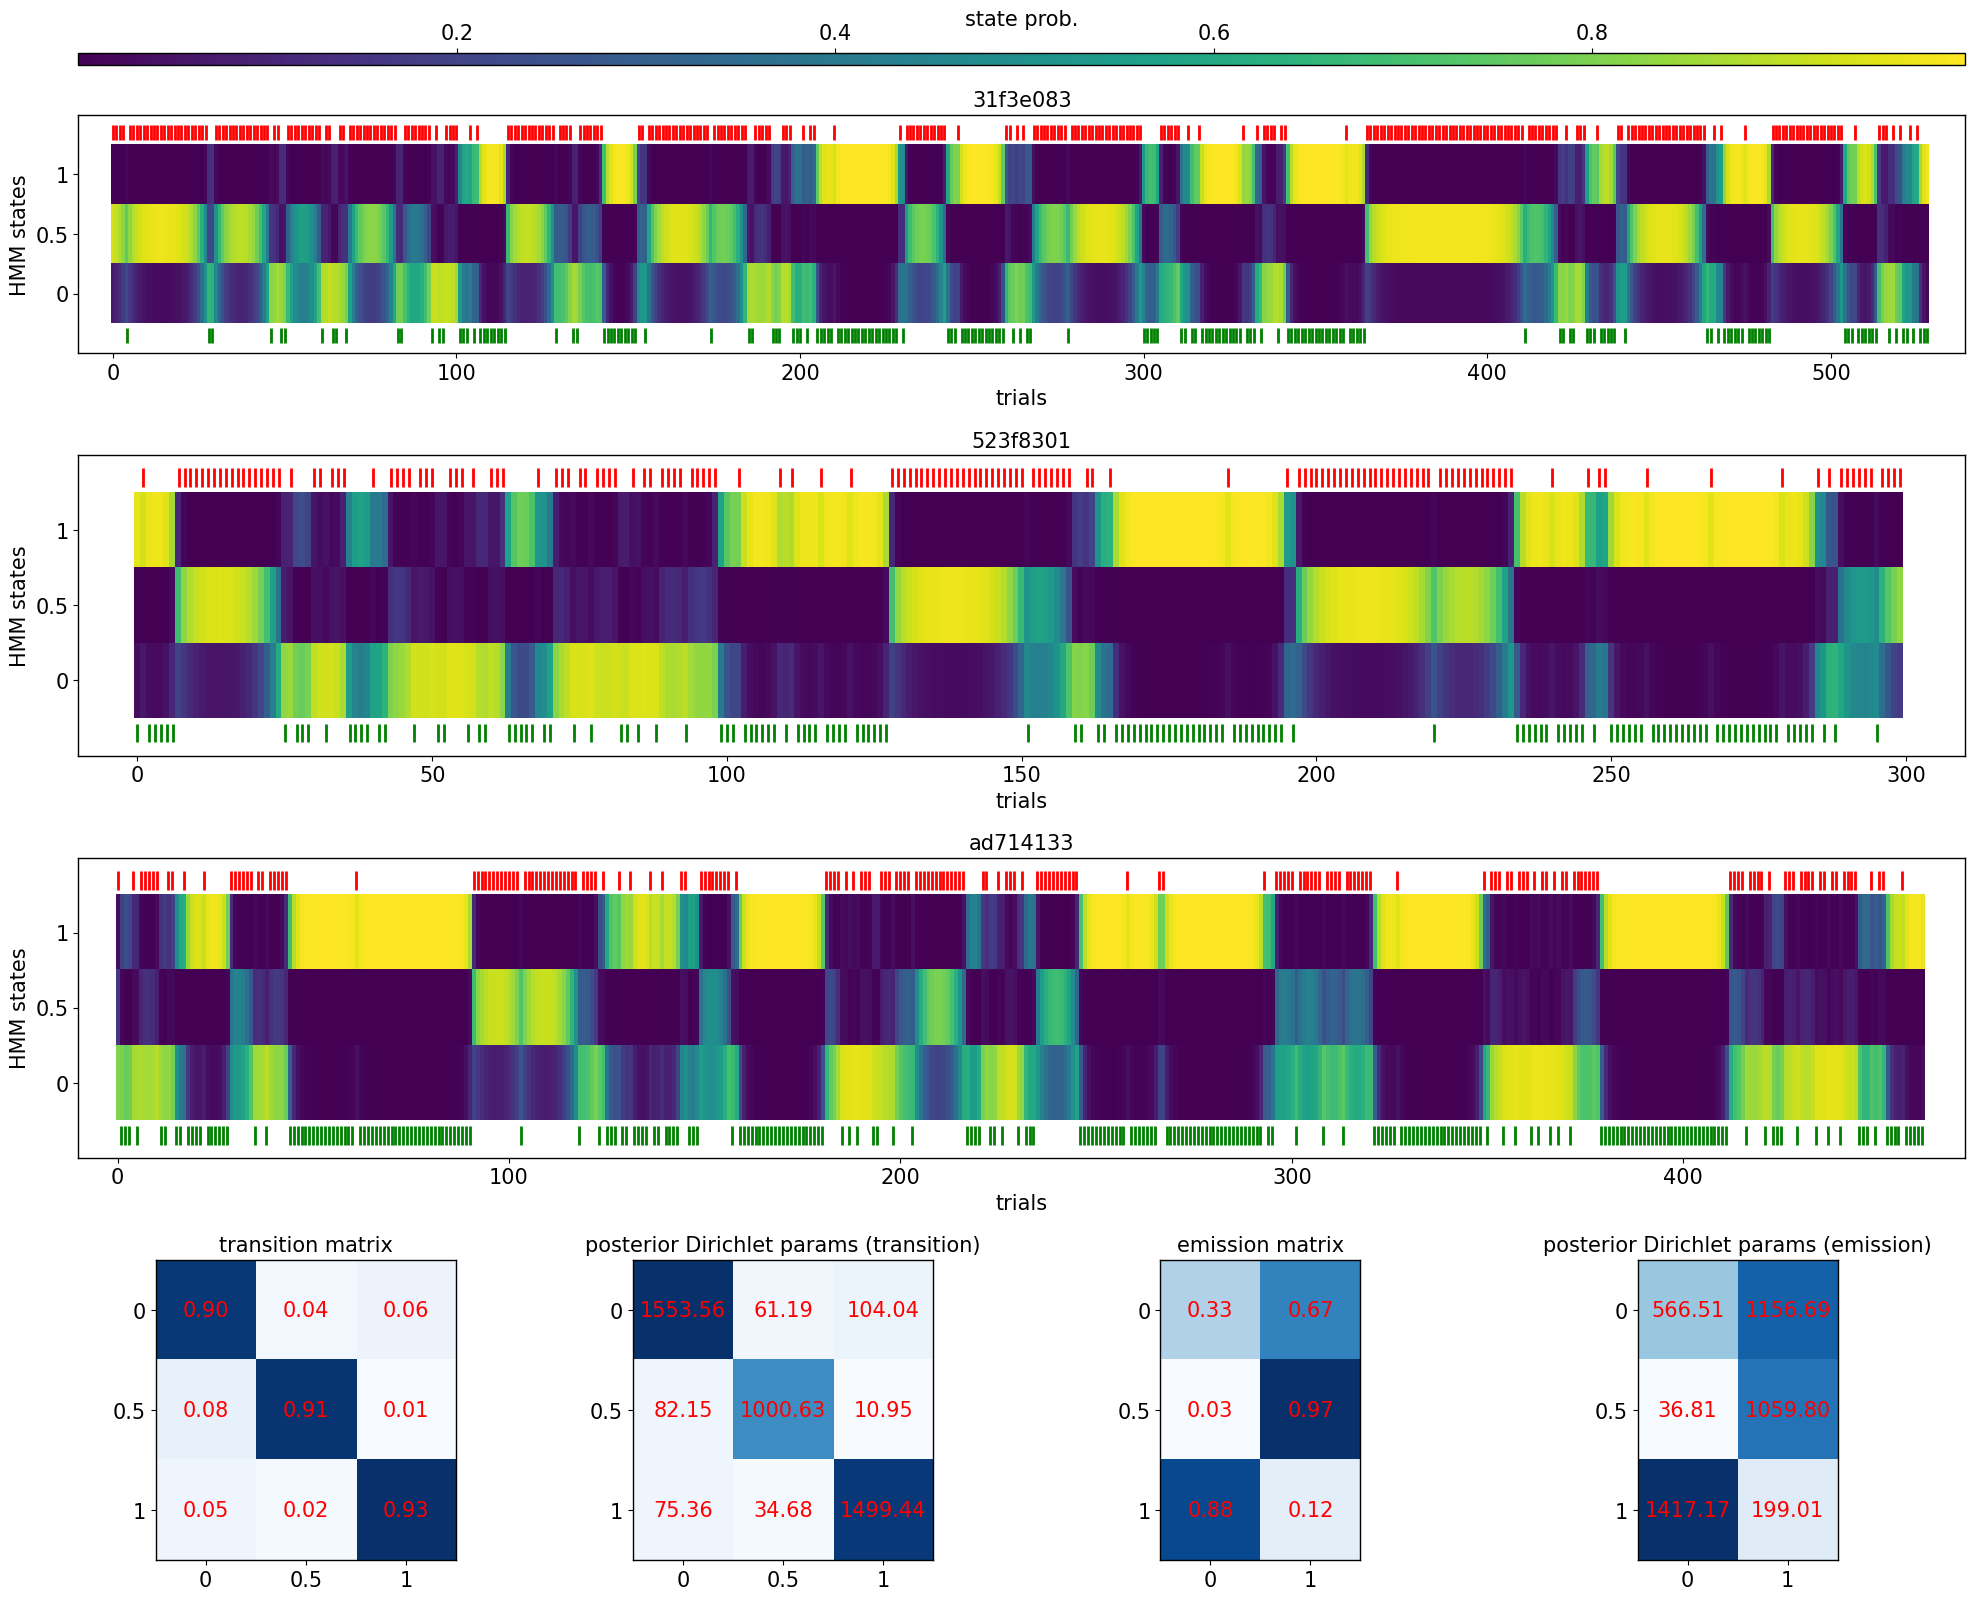

In [26]:
multi_sess_hmm = vhmm.VariationalCategoricalHMM(n_components=3)
multi_sess_hmm.fit(aligned_train_ys, lengths)

aligned_train_states = multi_sess_hmm.predict_proba(aligned_train_ys)
multi_sess_trial_idxs = np.cumsum([0] + lengths)

train_states = [
    aligned_train_states[multi_sess_trial_idxs[i-1]:multi_sess_trial_idxs[i]] for i in range(1, len(multi_sess_trial_idxs))
]

a_constraint = multi_sess_hmm.transmat_
b_constraint = multi_sess_hmm.emissionprob_
pi_posterior = multi_sess_hmm.startprob_posterior_
a_posterior = multi_sess_hmm.transmat_posterior_
b_posterior = multi_sess_hmm.emissionprob_posterior_

# manually check quality of vhmm fit
plot_multi_session_hmm_results(
    states=train_states,
    choices=train_ys,
    pids=np.array(pids)[train_pid_idxs],
    params=(a_constraint, b_constraint, a_posterior, b_posterior)
)

In [28]:
# fit bmm 

train_ds_flat = np.vstack(train_ds).squeeze()
train_ys_flat = np.vstack(train_ys).squeeze()

with pm.Model() as beta_model:
    eta = pm.Gamma("eta", alpha = 5, beta = 1, shape = 2)
    nu = pm.Gamma("nu", alpha = 1, beta = 5, shape = 2)
    # pymc uses rate lambda but scipy uses scale=1/lambda
    alpha = pm.Exponential("a", eta, shape = 2)
    beta = pm.Exponential("b", nu, shape = 2)
    dk = BetaProcess('d', train_ys_flat, alpha, beta, observed=train_ds_flat)
    step = pm.NUTS()     
    trace = pm.sample(draws=1000, step=step, chains=2, progressbar=True)  
    beta_ppc = pm.sample_posterior_predictive(
        trace, var_names=["a", "b", "d", "eta", "nu"], random_seed=seed
    )

a0, a1 = beta_ppc["a"].mean(0)
b0, b1 = beta_ppc["b"].mean(0)
a0_prior, a1_prior = beta_ppc["eta"].mean(0)
b0_prior, b1_prior = beta_ppc["nu"].mean(0)
print([a0, b0, a1, b1])
print([a0_prior, b0_prior, a1_prior, b1_prior])

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a, nu, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


[0.5241713826053751, 0.6238218087644918, 0.7014425585641044, 0.4253649665637573]
[3.931729063111137, 0.3449743696620961, 3.4982972999056754, 0.36935929079785534]


In [73]:
# initialize bmm-hmm

startprob = multi_sess_hmm.startprob_
pi_prior = multi_sess_hmm.startprob_posterior_
a_prior = multi_sess_hmm.transmat_posterior_
phi_prior = multi_sess_hmm.emissionprob_posterior_

states = [0, 1, 2]
init_pi = {0: np.log(startprob[0]), 1:np.log(startprob[1]), 2: np.log(startprob[2])}
init_a = {
        0: {0: np.log(a_constraint[0][0]), 1: np.log(a_constraint[0][1]), 2: np.log(a_constraint[0][2])},
        1: {0: np.log(a_constraint[1][0]), 1: np.log(a_constraint[1][1]), 2: np.log(a_constraint[1][2])},
        2: {0: np.log(a_constraint[2][0]), 1: np.log(a_constraint[2][1]), 2: np.log(a_constraint[2][2])} }
init_phi = {
        0: {0: np.log(b_constraint[0][0]), 1: np.log(b_constraint[0][1])},
        1: {0: np.log(b_constraint[1][0]), 1: np.log(b_constraint[1][1])},
        2: {0: np.log(b_constraint[2][0]), 1: np.log(b_constraint[2][1])}
         }
init_beta_a = [a1, a0]
init_beta_b = [b1, b0]

beta_a_prior = [a1_prior, a0_prior]
beta_b_prior = [b1_prior, b0_prior]

In [74]:
# fit bmm-hmm
bmm_hmm = Constrained_BMM_HMM(
    d, 
    init_pi, 
    init_a, 
    init_phi, 
    init_beta_a, 
    init_beta_b, 
    pi_prior, 
    a_prior, 
    phi_prior,
    beta_a_prior, 
    beta_b_prior,
    tol=1e-1
)
bmm_hmm.update(d)

BMM Convergence Achieved:  True
log-likelihood: 306.36631976493
BMM Convergence Achieved:  True
log-likelihood: 306.82572826159117
BMM Convergence Achieved:  True
log-likelihood: 307.03914590805067
BMM Convergence Achieved:  True
log-likelihood: 307.326125589215
BMM Convergence Achieved:  True
log-likelihood: 307.9173040725397
BMM Convergence Achieved:  True
log-likelihood: 308.22285593607563
BMM Convergence Achieved:  True
log-likelihood: 308.24037460517155


In [75]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

In [76]:
# inference

multi_A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

multi_B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
multi_preds, multi_probs = posterior_inference(bmm_hmm, d)

plotting

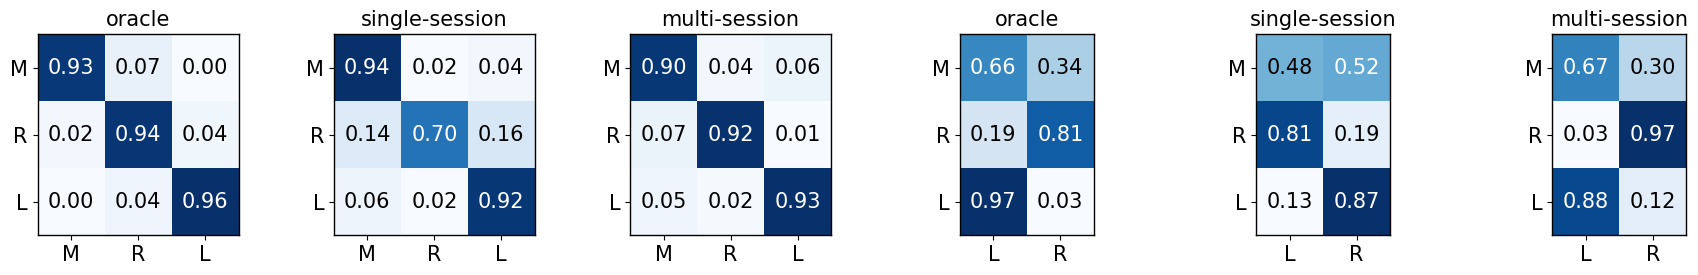

In [54]:
fig, axes = plt.subplots(1, 6, figsize=(18,3))
axes[0].imshow(oracle_A, cmap='Blues')
axes[0].set_xticks([0,1,2], ["M", "R", "L"])
axes[0].set_yticks([0,1,2], ["M", "R", "L"])
axes[0].set_title("oracle")

for i in range(oracle_A.shape[0]):
    for j in range(oracle_A.shape[1]):
        if i == j:
            axes[0].text(j, i, f'{oracle_A[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[0].text(j, i, f'{oracle_A[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[1].imshow(single_A, cmap='Blues')
axes[1].set_xticks([0,1,2], ["M", "R", "L"])
axes[1].set_yticks([0,1,2], ["M", "R", "L"])
axes[1].set_title("single-session")

for i in range(single_A.shape[0]):
    for j in range(single_A.shape[1]):
        if i == j:
            axes[1].text(j, i, f'{single_A[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[1].text(j, i, f'{single_A[i, j]:.2f}', ha='center', va='center', color='k')
            
            
axes[2].imshow(multi_A, cmap='Blues')
axes[2].set_xticks([0,1,2], ["M", "R", "L"])
axes[2].set_yticks([0,1,2], ["M", "R", "L"])
axes[2].set_title("multi-session")

for i in range(multi_A.shape[0]):
    for j in range(multi_A.shape[1]):
        if i == j:
            axes[2].text(j, i, f'{multi_A[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[2].text(j, i, f'{multi_A[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[3].imshow(oracle_B, cmap='Blues')
axes[3].set_xticks([0,1], ["L", "R"])
axes[3].set_yticks([0,1,2], ["M", "R", "L"])
axes[3].set_title("oracle")

for i in range(oracle_B.shape[0]):
    for j in range(oracle_B.shape[1]):
        if oracle_B[i, j] > 0.5:
            axes[3].text(j, i, f'{oracle_B[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[3].text(j, i, f'{oracle_B[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[4].imshow(single_B, cmap='Blues')
axes[4].set_xticks([0,1], ["L", "R"])
axes[4].set_yticks([0,1,2], ["M", "R", "L"])
axes[4].set_title("single-session")

for i in range(single_B.shape[0]):
    for j in range(single_B.shape[1]):
        if single_B[i, j] > 0.5:
            axes[4].text(j, i, f'{single_B[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[4].text(j, i, f'{single_B[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[-1].imshow(multi_B, cmap='Blues')
axes[-1].set_xticks([0,1], ["L", "R"])
axes[-1].set_yticks([0,1,2], ["M", "R", "L"])
axes[-1].set_title("multi-session")

for i in range(multi_B.shape[0]):
    for j in range(multi_B.shape[1]):
        if multi_B[i, j] > 0.5:
            axes[-1].text(j, i, f'{multi_B[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[-1].text(j, i, f'{multi_B[i, j]:.2f}', ha='center', va='center', color='k')
            
plt.tight_layout()
# plt.savefig("./plots/bmm_hmm_model_params.png", dpi=400)

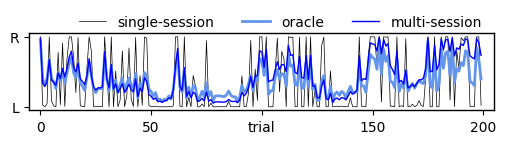

In [129]:
plt.figure(figsize=(6,1))
plt.plot(single_probs[:200], color="k", linewidth=.5, label="single-session")
plt.plot(oracle_probs[:200], color="cornflowerblue", linewidth=2., label="oracle")
plt.plot(multi_probs[:200], color="b", linewidth=1., label="multi-session")
plt.xlim(-5, 205)
plt.yticks([0, 1], ["L", "R"], fontsize=10)
plt.xticks([0, 50, 100, 150, 200], [0, 50, "trial", 150, 200],fontsize=10)
plt.legend(bbox_to_anchor=(1, 1.4), ncol=3, frameon=False, fontsize=10)
plt.savefig("./plots/bmm_hmm_traces.png", dpi=200)